In [179]:
import os
import sys
import quandl
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce

In [180]:
## Register for Quandl at https://www.quandl.com/
## Remove API Key before sharing publicly

quandl.ApiConfig.api_key = "G-xocF-9symNJcKdRF6t"

In [181]:
## Starting with $AAPL, but you can choose any ticker here

data = quandl.get('EOD/AAPL')

In [216]:
## For now, drop all the columns except daily closing price

closing_price_df = pd.DataFrame(data['Close'])
closing_price_df = closing_price_df.reset_index(level=0)

## Adjust for Stock Split

In [251]:
## You can find this data on the company's investment site
## Create data frame to adjust for split

stock_splits_df = pd.DataFrame({'split_date':['1987-06-16',
                                              '2000-06-21',
                                              '2005-01-28',
                                              '2014-06-09'],
                                'split_amount':[2,
                                                2,
                                                2,
                                                7]})

In [252]:
## Eventually we should create a repo
## But for now I'll keep them here

def reformat_for_cum_split(split_df):
    split_df.sort_values('split_date', ascending = False)
    
    cum_splits = split_df['split_amount']
    empt_list = []
    
    for row in range(len(cum_splits)):
        empt_list.append(reduce(lambda x, y: x*y, cum_splits))
        cum_splits = cum_splits[1:]
    
    split_df['split_amount'] = empt_list
    return(split_df)
    
def change_col_datetime(split_df):
    empt_list = []

    for i in range(len(split_df['split_date'])):
        empt_list.append(pd.to_datetime(split_df['split_date'][i]))

    split_df['split_date'] = empt_list
    return(split_df)

In [253]:
stock_splits_df = reformat_for_cum_split(stock_splits_df)
stock_splits_df = change_col_datetime(stock_splits_df)

In [254]:
## A bunch of cleaning

merge_df = pd.merge(closing_price_df, stock_splits_df, how = 'left', left_on = 'Date', right_on = 'split_date')
merge_df['split_amount'] = merge_df['split_amount'].fillna(method='bfill')
merge_df['split_amount'] = merge_df['split_amount'].fillna(1)
merge_df['split_adj_price'] = merge_df['Close'] / merge_df['split_amount']
clean_stock_data_df = merge_df.drop(['split_amount', 'split_date','Close'], axis=1)

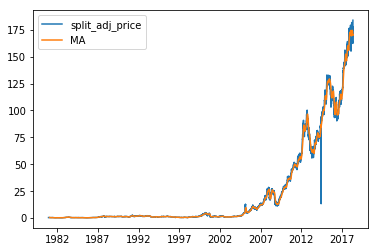

In [257]:
plt.plot( 'Date', 'split_adj_price', data=clean_stock_data_df)
plt.plot( 'Date', 'MA', data=clean_stock_data_df)
plt.legend()

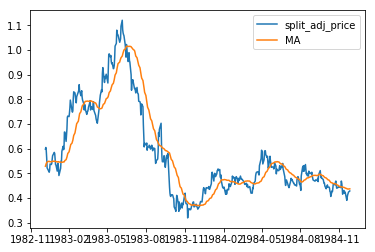

In [258]:

plt.plot( 'Date', 'split_adj_price', data=clean_stock_data_df.iloc[499:999])
plt.plot( 'Date', 'MA', data=clean_stock_data_df.iloc[499:999])
plt.legend()

## Fundamental Analysis

In [112]:
aapl_df = quandl.get_table('SHARADAR/SF1', calendardate='2017-12-31', ticker='AAPL')